# fanCE Tutorial

$\texttt{fanCE}$ (pronounced "fan-SEE-EE" for flexible analytic Chemical Evolution) is a one-zone chemical evolution code that implements the [Weinberg, Andrews, & Freudenburg (2017)](https://iopscience.iop.org/article/10.3847/1538-4357/837/2/183) analytic solution for a flexible, two-parameter star formation history $\propto(1-e^{-t/\tau_1})\cdot e^{-t/\tau_2}$. This corresponds to a star formation history that rises linearly on a timescale $\tau_1$ and then falls exponentially on a timescale $\tau_2$ for $\tau_1>\tau_2>0$. 

In this tutorial, we will use $\texttt{fanCE}$ to generate the star formation history, time evolution of [Mg/H], [Fe/H], and [Mg/Fe], and evolution of mean stellar <br> $\langle$age$\rangle$, $\langle$[Mg/H]$\rangle$, and $\langle$[Mg/Fe]$\rangle$ for the reference model in Gountanis et al. 2024. We will also show how to modify the $\texttt{fanCE}$ defualt parameters to explore alternative assumptions and interpret other galaxies or stellar populations.

Let's begin by importing a few modules we will need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fance.models import waf2017, fance
from fance.par import DefaultfanCEParSet
from fance.plotting import plotSFH, plotGas, plotStellar
from fance.utils import stellar_props

## fanCE Parameters

The table below defines the $\texttt{fanCE}$ parameters and shows their corresponding defualt values. Parameters with default values listed as <code>None</code> are computed in $\texttt{fanCE}$ using <code>aFeEq</code> and <code>mu</code> if set to <code>None</code>. <code>IaDTD_fn</code> is the functional form of the SN Ia DTD and can either be a <code>'powerlaw'</code> with a slope of -1.1 or an <code>'exponential'</code> with an e-folding time set by <code>tauIa</code>. Additional information about the parameters can be found in <code>models.py</code>, <code>par.py</code>, and in Gountanis et al. 2024. 

| Parameter | Definition | Default Value |
| :---: | :---: | :---: |
| t_start | star formation start time | 0.5 [Gyr] |
| t_0 | age of Universe at observed redshift | 14 [Gyr] |
| dt | time step | 0.02 [Gyr] |
| tauSFE | star formation efficiency timescale | 1.0 [Gyr] |
| tauSFH1 | star formation history rise timescale | 2.0 [Gyr] |
| tauSFH2 | star formation history  decline timescale | 8.0 [Gyr] |
| aFeCC | [Mg/Fe] plateau from the CCSN yield ratio | 0.45 |
| aFeEq | [Mg/Fe] late-time equilibrium ratio | 0 |
| mu | constant used to determine the Type Ia Fe yield | 1.1 |
| yOCC | IMF-averaged CCSN O yield | None |
| yMgCC | IMF-averaged CCSN Mg yield | None |
| yFeCC | IMF-averaged CCSN Fe yield | None |
| yFeIa | IMF-averaged SNIa Fe yield | None |
| fRetCC | fraction of metals returned to the ISM by CCSNe | 1.0 |
| r | mass recycling parameter | 0.4 |
| eta | mass loading factor | 0.3 |
| tauIa | e-folding time for SNIa DTD | 0 [Gyr] |
| SolarO | Solar O mass fraction | 0.00733 |
| SolarMg | Solar Mg mass fraction | 0.000671 |
| SolarFe | Solar Fe mass fraction | 0.00137 |
| IaDTD_fn | functional form of the SN Ia DTD | 'powerlaw' |

## Star Formation History and Gas Abundance Evolution

In this section, we will use $\texttt{fanCE}$ to generate star formation histories and time evolutions of the gas-phase abundances [O/H], [Mg/H], [Fe/H], [O/Fe], and [Mg/Fe] for different models using the function <code>fance()</code>. <code>fance()</code> takes in the parameters listed in the table above and returns the star formation rate and [O/H], [Mg/H], [Fe/H], [O/Fe], and [Mg/Fe] evaluated at the times listed in the outputted time array. The outputted star formation history is normalized to give the fraction of the galaxy’s stellar mass formed per timestep.

Let's begin by setting our parameters equal to the $\texttt{fanCE}$ default parameters: 

In [2]:
# load fanCE default parameters
par = DefaultfanCEParSet()

# print parameters
print(par)

{'t_start': 0.5, 't0': 14.0, 'dt': 0.02, 'tauSFE': 1.0, 'tauSFH1': 2.0, 'tauSFH2': 8.0, 'aFeCC': 0.45, 'aFeEq': 0.0, 'mu': 1.1, 'yOCC': None, 'yMgCC': None, 'yFeCC': None, 'yFeIa': None, 'fRetCC': 1.0, 'r': 0.4, 'eta': 0.3, 'tauIa': 0, 'tDminIa': 0.15, 'SolarO': 0.00733, 'SolarMg': 0.000671, 'SolarFe': 0.00137, 'IaDTD_fn': 'powerlaw'}


Now we can call <code>fance()</code> and plot the resulting star formation history using <code>plotSFH()</code>. <code>plotSFH()</code> plots star formation rate versus time, normalized to give the galaxy’s stellar mass formed per Gyr. 

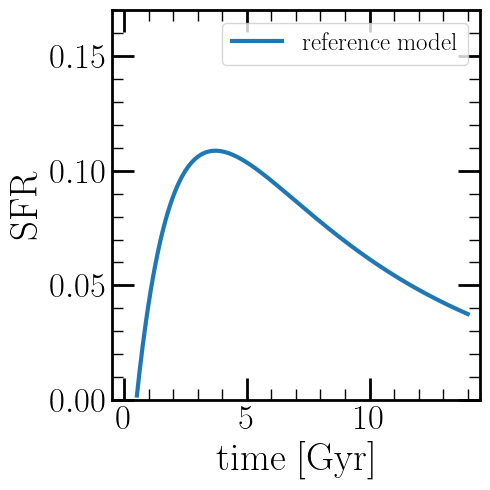

In [3]:
# call fanCE
t, sfr, OH, MgH, FeH, OFe, MgFe = fance(**par)

# plot the reference model SFH
ax = plotSFH(t, sfr, labels="reference model", c="C0")

The $\texttt{fanCE}$ defualt parameters can be updated to explore alternative assumptions and interpret other galaxies or stellar populations.

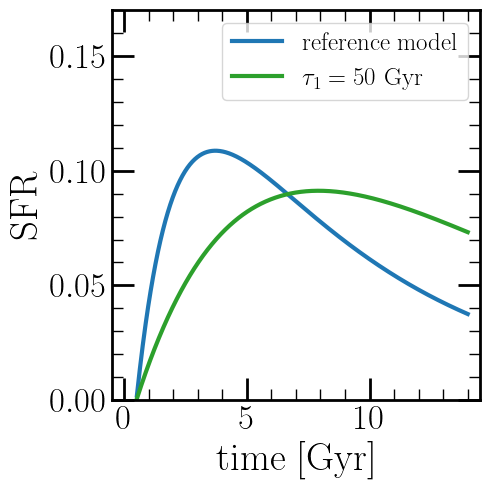

In [4]:
# plot the reference model SFH
ax = plotSFH(t, sfr, labels="reference model", c="C0")

# update tau1
par["tauSFH1"] = 50

# run fanCE
t1, sfr1, OH1, MgH1, FeH1, OFe1, MgFe1 = fance(**par)

# add results to the plot
ax = plotSFH(t1, sfr1, labels="$\\tau_1=50$ Gyr", ax=ax, c="C2")

We can plot [Mg/H], [Fe/H], and [Mg/Fe] versus time using <code>plotGas()</code>. [O/H] and [O/Fe] are not included in <code>plotGas()</code> since they have identical evolution tracks to [Mg/H] and [Mg/Fe], respectively.

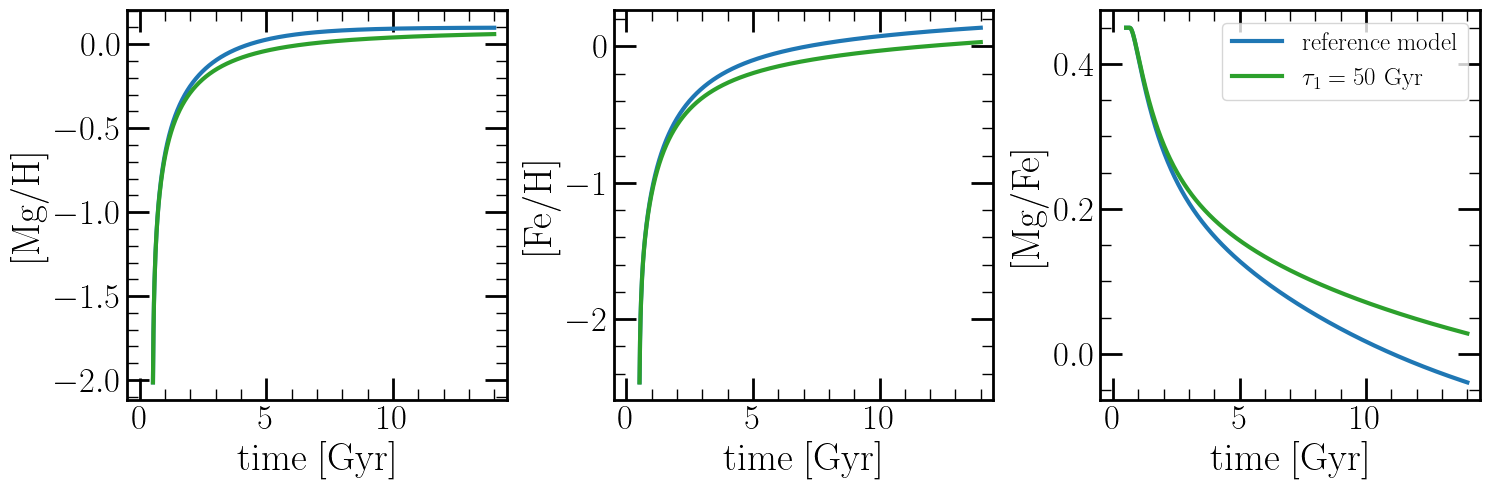

In [5]:
ax = plotGas(t, MgH, FeH, MgFe, labels="reference model", c="C0")
ax = plotGas(t1, MgH1, FeH1, MgFe1, labels="$\\tau_1=50$ Gyr", ax=ax, c="C2")

## Mean Age and Stellar Abundance Evolution

In the this section we will use the <code>stellar_props()</code> to compute the light-weighted, log-averaged stellar age and abundances for different models. 

Inferred stellar population properties and elemental abundances from SSP-equivalent measurements are similar to the light-weighted, log-averaged ages and abundances in $\texttt{fanCE}$. The light-weighted, log-averaged age (denoted as $\langle$age$\rangle=10^{\langle\log_{10}(\mathrm{age})\rangle}$ for brevity) is defined as 

\begin{equation}
\langle\log_{10}(\mathrm{age})\rangle = \frac{\int_{0}^{t_{\mathrm{cut}}} \dot{M}_{\star}(t) \cdot \log_{10}(t_{\mathrm{0}}-t) \cdot w(t)\,dt }{\int_{0}^{t_{\mathrm{cut}}} \dot{M}_{\star}(t) \cdot w(t) \,dt }
\end{equation}

and the light-weighted, log-averaged abundance ratio $\langle[\mathrm{X/H}]\rangle$ of element $X$ is defined as 

\begin{equation}
\langle[\mathrm{X/H}]\rangle = \frac{\int_{0}^{t_{\mathrm{cut}}} \dot{M}_{\star}(t) \cdot [\mathrm{X/H}](t) \cdot w(t)\,dt }{\int_{0}^{t_{\mathrm{cut}}} \dot{M}_{\star}(t) \cdot w(t) \,dt },
\end{equation},

where $\dot{M}_{\star}(t)$ is the SFR, $t_{\mathrm{0}}$ is the age of the Universe at the observed redshift, $\mathrm{[X/H]}(t)$ is the gas-phase abundance, and $w(t)$ is a light-weighting function. Choosing <code>light_weighted=True</code> in <code>stellar_props()</code> sets 

\begin{equation}
w(t)_{\mathrm{light}} = L_\mathrm{V}/M = 1.5\left(\frac{t_{\mathrm{0}}-t}{\mathrm{Gyr}} + 0.1\right)^{-0.90} \frac{L_{\odot}}{M_{\odot}}
\label{eqn:weighing}
\end{equation}. 

Choosing <code>light_weighted=False</code> sets $w(t)=1$, resulting in mass-weighted stellar properties. The light-weighting function can be customized by editing <code>stellar_props()</code> in <code>utils.py</code>.

Let's use <code>stellar_props()</code> to compute the light-weighted $\langle$age$\rangle$ and stellar abundances $\langle$[O/H]$\rangle$, $\langle$[Mg/H]$\rangle$, $\langle$[Fe/H]$\rangle$, $\langle$[O/Fe]$\rangle$, $\langle$[Mg/Fe]$\rangle$ evaluated at the times outputted by the function <code>fance()</code>: 

In [6]:
# reference model
mean_age, OHStar, MgHStar, FeHStar, OFeStar, MgFeStar = stellar_props(
    t, par["t0"], sfr, OH, MgH, FeH, light_weighted=True
)

# model with tau_1 = 50 Gyr
mean_age1, OHStar1, MgHStar1, FeHStar1, OFeStar1, MgFeStar1 = stellar_props(
    t1, par["t0"], sfr1, OH1, MgH1, FeH1, light_weighted=True
)

We can plot $\langle$age$\rangle$, [Mg/H], $\langle$[Mg/H]$\rangle$, [Mg/Fe], and $\langle$[Mg/Fe]$\rangle$ versus time as well as $\langle$[Mg/H]$\rangle$ and $\langle$[Mg/Fe]$\rangle$ versus $\langle$age$\rangle$ using <code>plotStellar()</code>. [O/H], $\langle$[O/H]$\rangle$, [O/Fe], and $\langle$[O/Fe]$\rangle$ are not included in <code>plotStellar()</code> since they have identical evolution tracks to [Mg/H], $\langle$[Mg/H]$\rangle$, [Mg/Fe], and <br> $\langle$[Mg/Fe]$\rangle$, respectively.

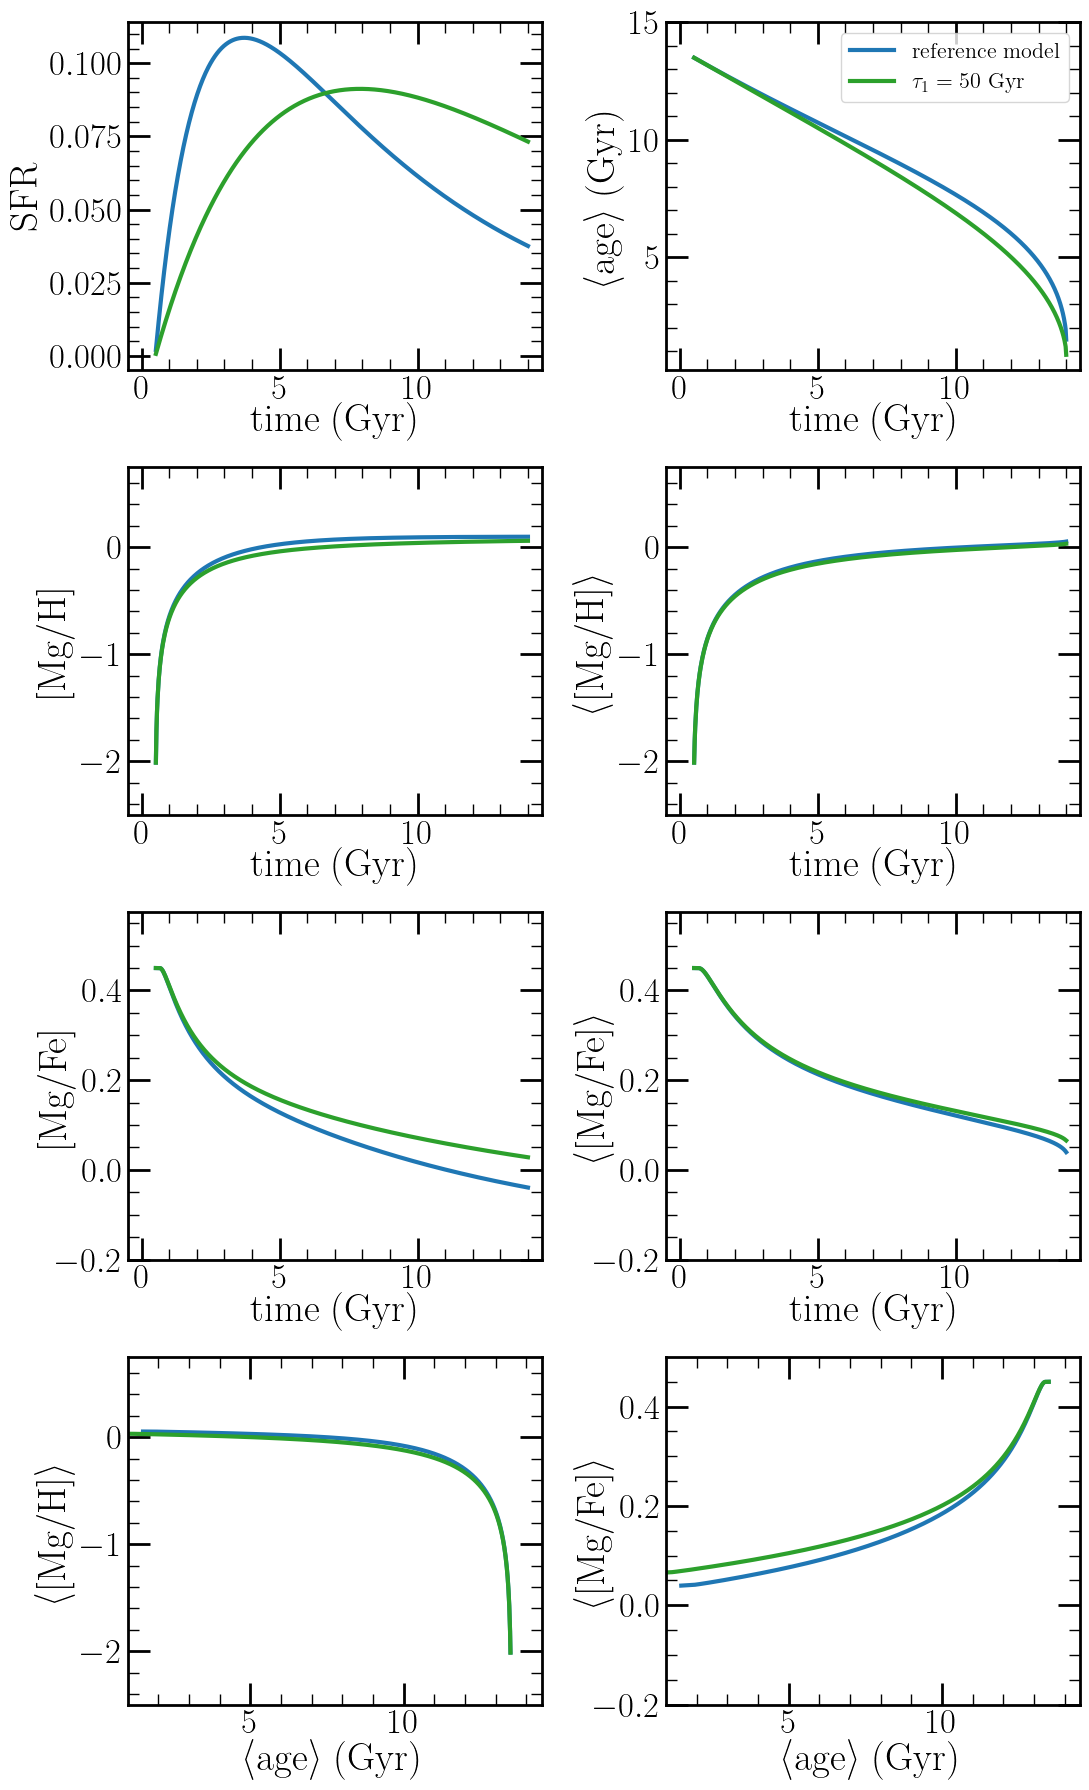

In [7]:
ax = plotStellar(
    t, sfr, mean_age, MgH, MgFe, MgHStar, MgFeStar, labels="reference model", c="C0"
)
ax = plotStellar(
    t1,
    sfr1,
    mean_age1,
    MgH1,
    MgFe1,
    MgHStar1,
    MgFeStar1,
    labels="$\\tau_1=50$ Gyr",
    ax=ax,
    c="C2",
)